In [2]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from shapley import SobolIndices, SobolKrigingIndices, create_df_from_gp_indices, create_df_from_mc_indices
from shapley.tests import Ishigami
from shapley.plots import set_style_paper, plot_violin
from shapley.kriging import test_q2

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
ishigami = Ishigami()
dim = ishigami.ndim
model = ishigami
input_distribution = ishigami.input_distribution

## Sobol indices with MC

In [4]:
max_budget = 10000
n_sample = int(max_budget/(2*dim))
n_boot = 5000
ylim = [-0.1, .6]

sobol = SobolIndices(input_distribution)
sobol.build_mc_sample(model, n_sample)
first_indices_mc = sobol.compute_indices(n_boot=n_boot)
df_first_indices_mc = create_df_from_mc_indices(first_indices_mc)

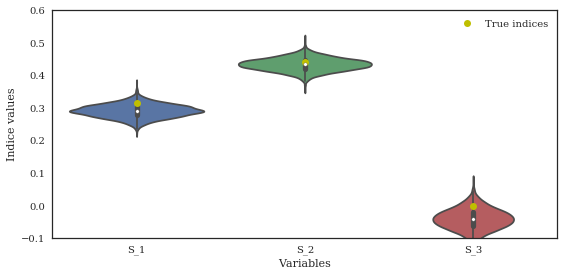

In [5]:
plot_violin(df_first_indices_mc, with_hue=False, true_indices=ishigami.first_order_sobol_indices, ylim=ylim)

In [7]:
model_budget = 100
basis = 'linear'
kernel = 'matern'
sobol_kriging = SobolKrigingIndices(input_distribution)
meta_model = sobol_kriging.build_meta_model(model, n_sample=model_budget, basis_type=basis, kernel=kernel)

In [14]:
n_sample = 500
n_realization = 300
evaluate_together = True
indiv_bootstraps = False
sobol_kriging.build_mc_sample(meta_model, n_sample, n_realization, evaluate_together=evaluate_together)
first_indices_gp = sobol_kriging.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstraps)
df_first_indices_gp = create_df_from_gp_indices(first_indices_gp)

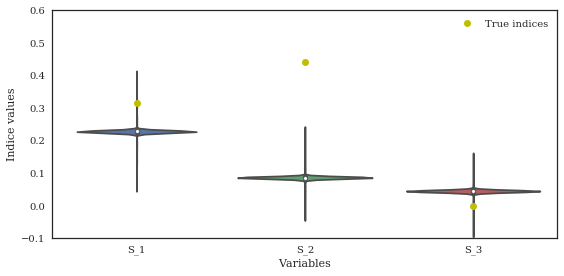

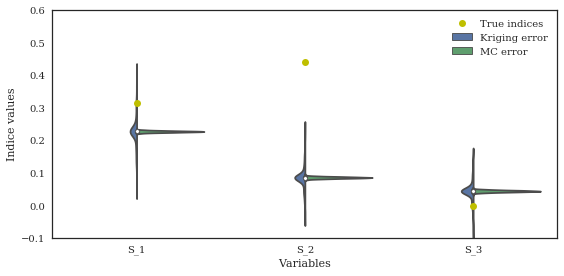

In [15]:
plot_violin(df_first_indices_gp, with_hue=False, true_indices=ishigami_true_indices, ylim=ylim)
plot_violin(df_first_indices_gp, with_hue=True, true_indices=ishigami_true_indices, ylim=ylim)

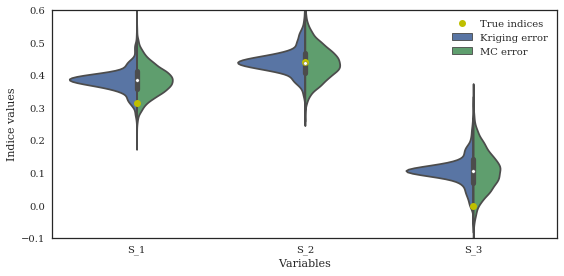

In [234]:
n_sample = 400
n_realization = 500
evaluate_together = False
indiv_bootstraps = False
sobol_kriging_indices.build_mc_sample(meta_model, n_sample, n_realization, evaluate_together=evaluate_together)
first_indices_gp = sobol_kriging_indices.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstraps)
df_first_indices_gp = create_df_from_gp_indices(first_indices_gp)
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax, split=True)
ax.plot(ishigami_true_indices, 'yo', markersize=7, label='True indices')
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()

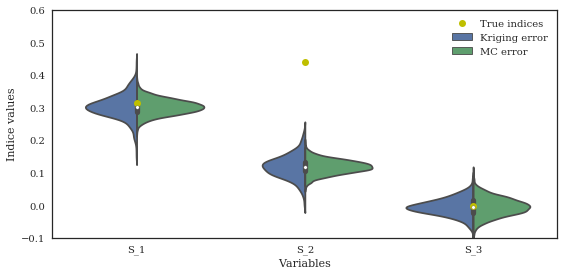

In [222]:
n_sample = 100
n_realization = 200
evaluate_together = True
indiv_bootstraps = False
sobol_kriging_indices.build_mc_sample(meta_model, n_sample, n_realization, evaluate_together=evaluate_together)
first_indices_gp = sobol_kriging_indices.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstraps)
df_first_indices_gp = create_df_from_gp_indices(first_indices_gp)
fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax, split=True)
ax.plot(ishigami_true_indices, 'yo', markersize=7, label='True indices')
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()

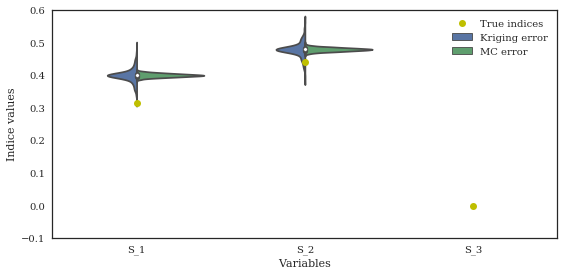

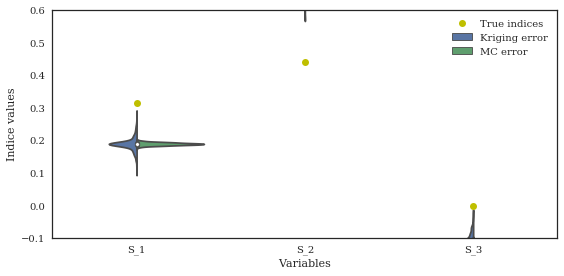

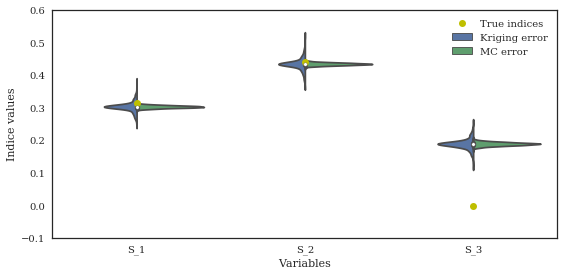

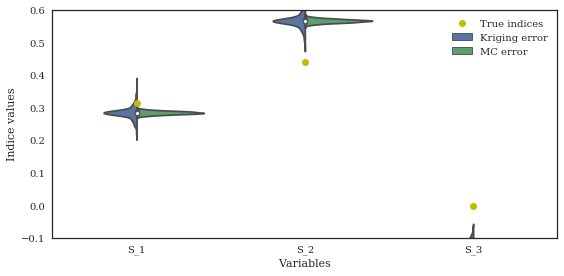

In [182]:
n_sample = 100
n_realization = 500
evaluate_together = True
indiv_bootstraps = True
for evaluate_together in [False, True]:
    for indiv_bootstraps in [False, True]:
        sobol_kriging_indices.build_mc_sample(meta_model, n_sample, n_realization, evaluate_together=evaluate_together)
        first_indices_gp = sobol_kriging_indices.compute_indices(n_boot=n_boot, indiv_bootstraps=indiv_bootstraps)
        df_first_indices_gp = create_df_from_gp_indices(first_indices_gp)
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.violinplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax, split=True)
        ax.plot(ishigami_true_indices, 'yo', markersize=7, label='True indices')
        ax.legend(loc=0)
        ax.set_ylim(ylim)
        fig.tight_layout()

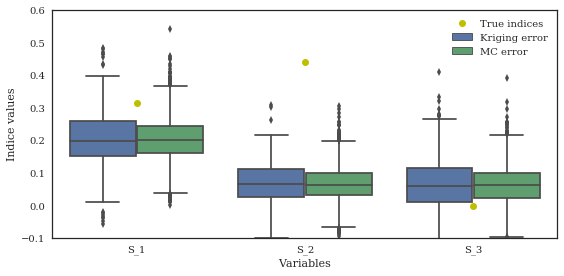

In [219]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(x='Variables', y='Indice values', data=df_first_indices_gp, hue='Error', ax=ax)
ax.plot(ishigami_true_indices, 'yo', markersize=7, label='True indices')
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()

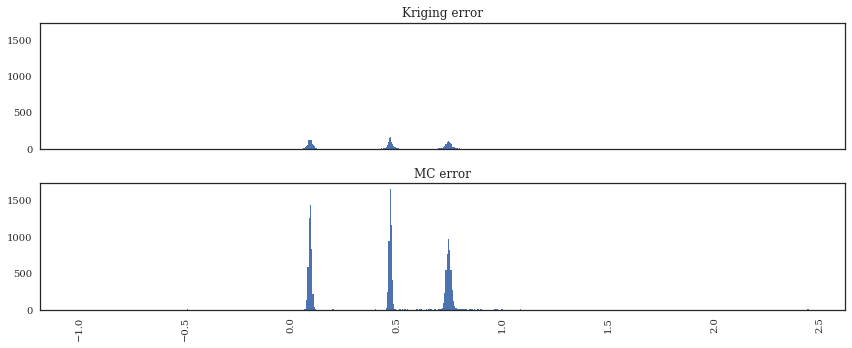

In [175]:
fig, ax = plt.subplots(2, 1, figsize=(12, 5), sharex=True, sharey=True)
df_first_indices_gp.hist(column='Indice values', by='Error', bins=500, ax=ax);
fig.tight_layout()

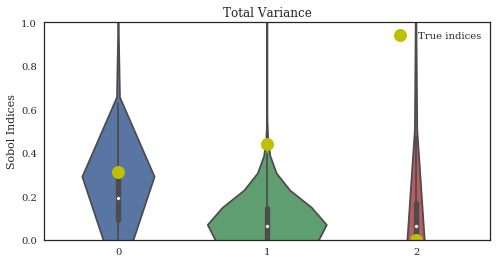

In [218]:
violin_plot_indices(first_indices_gp.reshape(dim, -1).T, true_indices=ishigami_true_indices, title="Total Variance", ylim=[0, 1])

In [29]:
max_budget = 50
n_sample_mc = int(max_budget/(2*dim))
n_boot = 1000

ot.RandomGenerator.SetSeed(0)
input_sample_1 = np.asarray(input_distribution.getSample(n_sample_mc))
input_sample_2 = np.asarray(input_distribution.getSample(n_sample_mc))

In [4]:
first_indices_mc = compute_indices(model, input_sample_1, input_sample_2, n_boot=n_boot)

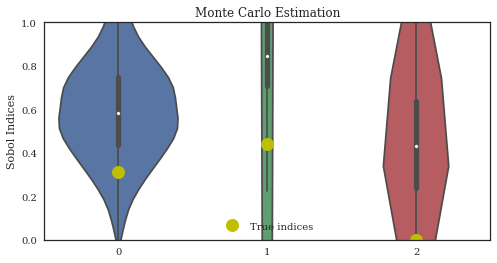

In [6]:
violin_plot_indices(first_indices_mc.T, true_indices=ishigami_true_indices, title="Monte Carlo Estimation", ylim=[0, 1])

## Sobol indices with kriging
We keep the same budget as previously

In [22]:
%%time
n_sample_kriging = max_budget
kriging = KrigingIndices(ot_model, input_distribution)
kriging.build_model(n_sample_kriging=n_sample_kriging, basis_type='constant')

Wall time: 280 ms


In [9]:
%%time
n_realization = 500
n_boot = 1000
n_sample_mc = 1500
first_indices = kriging.compute_indices(n_sample=n_sample_mc, n_realization=n_realization, n_boot=n_boot)

Wall time: 4min 24s


In [33]:
%%time
n_realization = 500
n_boot = 1000
n_sample_mc = 100
first_indices = kriging.compute_indices(n_sample=n_sample_mc, n_realization=n_realization, n_boot=n_boot)

Wall time: 2.21 s


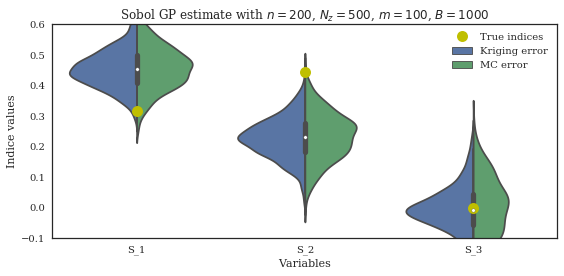

In [34]:
title = 'Sobol GP estimate with $n=%d$, $N_z=%d$, $m=%d$, $B=%d$' % (n_sample_kriging, n_realization, n_sample_mc, n_boot)
ylim = [-0.1, .6]

df_indices = create_df_from_gp_indices(first_indices)

fig, ax = plt.subplots(figsize=(8, 4))
sns.violinplot(x='Variables', y='Indice values', data=df_indices, hue='Error', ax=ax, 
               label='First order indices', split=True, gridsize=500)
ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
ax.set_title(title)
ax.legend(loc=0)
ax.set_ylim(ylim)
fig.tight_layout()
fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.pdf' % (n_sample_kriging, n_realization, n_sample_mc, n_boot))
fig.savefig('output/ishigami_sobolGP_n_%d_Nz_%d_m_%d_B_%d.png' % (n_sample_kriging, n_realization, n_sample_mc, n_boot))

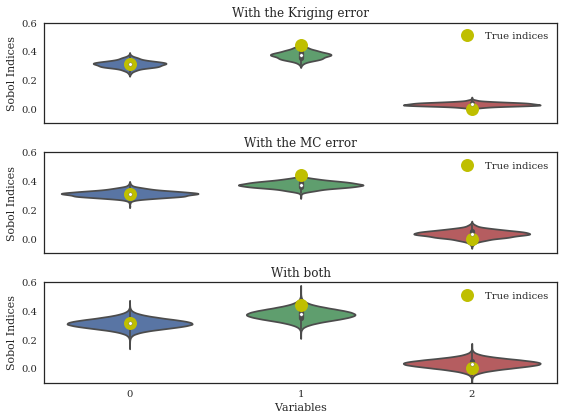

In [13]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 6))
violin_plot_indices(first_indices.mean(axis=2).T, true_indices=ishigami_true_indices, title="With the Kriging error", ylim=ylim, ax=axes[0])
violin_plot_indices(first_indices.mean(axis=1).T, true_indices=ishigami_true_indices, title="With the MC error", ylim=ylim, ax=axes[1])
violin_plot_indices(first_indices.reshape(dim, -1).T, true_indices=ishigami_true_indices, title="With both", xlabel='Variables', ylim=ylim, ax=axes[2])
fig.tight_layout()

In [38]:
first_indices.reshape(dim, -1).var(axis=1)

array([ 0.01103009,  0.0106554 ,  0.01604022])

In [37]:
var_MC = first_indices.var(axis=2).mean(axis=1)
var_kriging = first_indices.var(axis=1).mean(axis=1)
var_MC, var_kriging

(array([ 0.00824223,  0.00823467,  0.01437583]),
 array([ 0.0056368 ,  0.00428423,  0.00354207]))

In [40]:
var_MC + var_kriging

array([ 0.01387904,  0.0125189 ,  0.0179179 ])

In [17]:
df_indices_gp = create_df_from_gp_indices(first_indices)
df_indices_mc = create_df_from_indices(first_indices_mc)

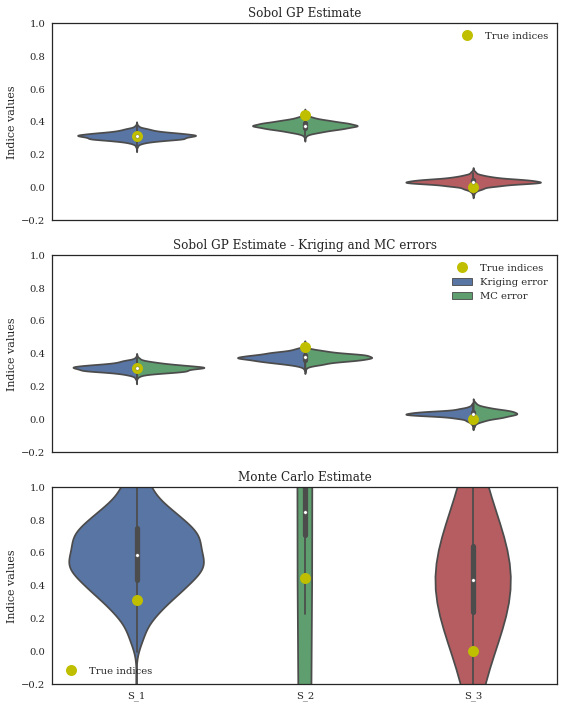

In [21]:
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 10))
ylim = [-.2, 1.]

ax = axes[0]
sns.violinplot(x='Variables', y='Indice values', data=df_indices_gp, ax=ax, gridsize=500)
ax.set_xlabel('')
ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
ax.set_title('Sobol GP Estimate')
ax.legend(loc=0)
ax.set_ylim(ylim)

ax = axes[1]
sns.violinplot(x='Variables', y='Indice values', data=df_indices_gp, hue='Error', ax=ax, split=True, gridsize=500)
ax.set_xlabel('')
ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
ax.set_title('Sobol GP Estimate - Kriging and MC errors')
ax.legend(loc=0)
ax.set_ylim(ylim)

ax = axes[2]
sns.violinplot(x='Variables', y='Indice values', data=df_indices_mc, ax=ax, split=True, gridsize=500)
ax.set_xlabel('')
ax.plot(ishigami_true_indices, 'yo', markersize=11, label='True indices')
ax.set_title('Monte Carlo Estimate')
ax.legend(loc=0)
ax.set_ylim(ylim)

fig.tight_layout()